In [48]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt

from DiffusionModel import DiffusionModel
from unet import UNet

import imageio

In [49]:
(trainX, trainY), (testX, testY) = load_data()

trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.


def sample_batch(batch_size, device):

    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device) # [B, 1, H, W]
    
    return torch.nn.functional.interpolate(data, 32)

In [50]:
device = 'cuda'
model = torch.load('model_paper2_epoch_39999').to(device)
diffusion_model = DiffusionModel(1000, model, device)

In [51]:
@torch.no_grad()
def sampling(self, n_samples=1, image_channels=1, image_size=(32, 32), use_tqdm=True):

    x = torch.randn((n_samples, image_channels, image_size[0], image_size[1]),
                        device=self.device)

    all_x = [x]

    progress_bar = tqdm if use_tqdm else lambda x : x

    for t in progress_bar(range(self.T, 0, -1)):
        z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

        t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

        beta_t = self.beta[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 
        alpha_t = self.alpha[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 
        alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 

        mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * self.function_aproximator(x, t-1))
        sigma = torch.sqrt(beta_t)

        x = mean + sigma * z
        all_x.append(x)

    return all_x

In [52]:
imgs = sampling(diffusion_model, n_samples=10)

100%|██████████| 1000/1000 [00:24<00:00, 40.11it/s]


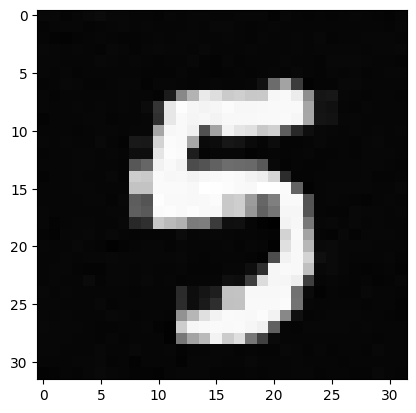

In [64]:
idx = 9 # select from 0 to 9 the desired number
plt.imshow(imgs[-1][idx].data.cpu().numpy().squeeze(0), cmap='gray')

In [89]:
indices = (1.1 ** np.linspace(0, 73, 80, dtype=int)).astype(int)
indices = np.array(sorted(list(set(list(indices))))).clip(1, 1000)
indices = sorted(1001 - indices)

In [91]:
imgs_np = [(e[idx].clip(0, 1).squeeze(0).data.cpu().numpy() * 255).astype(np.uint8) for e in imgs]
imgs_np = np.array(imgs_np)[indices]

In [92]:
imageio.mimsave('movie.gif', imgs_np)

In [93]:
imageio.mimsave('movie.mp4', imgs_np)